In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src/

/tf/notebooks/src


## Intialization

### GPU

In [3]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Packages

In [4]:
try:
    import pandas
except:
    !pip install pandas seaborn iterative-stratification nlpaug==0.0.20 tqdm click tensorflow_probability==0.11.1 tf2_resnets tensorflow_addons==0.11.1 image-classifiers==0.2.2

### Imports

In [5]:
import os
import gc
import random
import logging
import warnings

import numpy as np
import pandas as pd
# import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from dataloaders.pl import BalancedMelSamplerPL
from dataloaders.val import MelSampler
from dataloaders.utils import csv_to_dict, csv_to_dict_pl

from losses import NpairsLoss, MovingAverageBCE
from metrics import TFLWLRAP
from split_data import get_split
from train import get_model, get_callbacks
from models import NUM_FRAMES, Classifier, DeepMetricLearning

In [6]:
from params import *
from utils.logger import prepare_log_folder, create_logger

### Setup

In [7]:
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["SM_FRAMEWORK"] = "tf.keras"

physical_devices = tf.config.list_physical_devices("GPU")
for i in range(len(physical_devices)):
    tf.config.experimental.set_memory_growth(physical_devices[i], True)
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

## Main

In [8]:
def main(fold_idx, df_pl, saved_path, pretrained_path="", pl_threshold=0.5):
    os.makedirs(os.path.join(saved_path, f"fold{fold_idx}"), exist_ok=True)
    
    df_pl['pl'] = df_pl[f'pl_fold_{fold_idx}']
    df_pl['max_score'] = df_pl['pl'].apply(lambda x: np.max(x))
    df_pl = df_pl[df_pl['max_score'] > pl_threshold].reset_index(drop=True)

    print(' -> Preparing Data \n')
    
    train_data = pd.read_csv("../data/new_train_tp.csv")
    train_index, val_index = get_split(fold=fold_idx)
    
    fold_train_dict = csv_to_dict(train_data.iloc[train_index])
    fold_valid_dict = csv_to_dict(train_data.iloc[val_index])
    pl_data = csv_to_dict_pl(df_pl) 

    balanced_train_data_loader = BalancedMelSamplerPL(
        fold_train_dict,
        pl_data,
        batch_size=64,
        max_length=NUM_FRAMES,
        n_classes=24,
        use_cutmix=True,
        n_classes_in_batch=8,
        pl_threshold=pl_threshold,
    )

    valid_data_loader = MelSampler(
        fold_valid_dict,
        batch_size=64,
        n_classes=24,
        max_length=NUM_FRAMES,
    )

    print(' -> Preparing Model \n')
    model = get_model(
        saved_path=saved_path,
        pretrained_with_contrastive=False,
        pretrained_path=pretrained_path,
    )
    model._build()
    
    scheduler = tfa.optimizers.Triangular2CyclicalLearningRate(
        initial_learning_rate=1e-4,
        maximal_learning_rate=1e-3,
        step_size=50,  # 15 steps per epoch
    )
    
    optimizer = tf.keras.mixed_precision.experimental.LossScaleOptimizer(
        tfa.optimizers.Lookahead(
            tf.keras.optimizers.Adam(
                learning_rate=scheduler
            ),
            10,
            0.5,
        ),
        "dynamic",
    )
    
    step_per_epoch = int((len(fold_train_dict)) / balanced_train_data_loader.batch_size)
    ma_bce = MovingAverageBCE(
        train_data.iloc[train_index],
        start_apply_step=20 * step_per_epoch,
        momentum=0.9,
        name="moving_average_loss",
    )
    
    model.compile(
        optimizer=optimizer,
        metrics=[TFLWLRAP(num_classes=24, name="lwlrap")],
        metric_loss_fn=NpairsLoss(temperature=0.1, name="n_pairs"),
        classification_loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        moving_average_bce=ma_bce,
    )   

    print(' -> Training Model \n')

    callbacks = get_callbacks(False, fold_idx, saved_path=saved_path)
    
    steps_per_epoch = int((len(fold_train_dict)) / balanced_train_data_loader.batch_size)

    model.fit(
        balanced_train_data_loader,
        steps_per_epoch=steps_per_epoch,
        epochs=100,
        validation_data=valid_data_loader,
        callbacks=callbacks,
        verbose=2
    )
    
    model.save_weights(os.path.join(saved_path, f"fold{fold_idx}", "model_last.h5"))

In [9]:
DEBUG = True
pretrained_folder = "../logs/2021-02-04/3/"   # simple
# pretrained_folder = "../logs/2021-01-30/42/"  # mixstyle + iunterpolate + cbam
# pretrained_folder = "../logs/2021-01-31/8/"  # mixstyle + iunterpolate + cbam without relu
log_folder = "../logs/"

## Load PL

In [10]:
pl_folder = LOG_PATH + "2021-02-05/0/"

In [11]:
df_test = pd.read_csv(DATA_PATH + "sample_submission.csv")[["recording_id"]]
df_test['is_test'] = True


df_train_pl = pd.DataFrame(os.listdir(TRAIN_MELS_PATH), columns=["recording_id"])
df_train_pl["recording_id"] = df_train_pl["recording_id"].apply(lambda x:x[:-4])

df_tp = pd.read_csv(DATA_PATH + "new_train_tp.csv")
recordings = list(np.unique(df_tp["recording_id"].apply(lambda x:x.split('_')[0]).values))

df_train_pl["is_tp"] = df_train_pl["recording_id"].apply(lambda x: x in recordings)
df_train_pl = df_train_pl[df_train_pl["is_tp"] == 0]
df_train_pl['is_test'] = False
df_train_pl.drop('is_tp', axis=1, inplace=True)

In [12]:
pl_test = np.load(pl_folder + "preds/pl_test.npy")
pl_train = np.load(pl_folder + "preds_train/pl_train.npy")

In [13]:
for i in range(5):
    df_train_pl[f'pl_fold_{i}'] = list(pl_train[i])
for i in range(5):
    df_test[f'pl_fold_{i}'] = list(pl_test[i])
    
df_pl = pd.concat([df_test, df_train_pl]).sample(frac=1).reset_index(drop=True)

In [14]:
PL_THRESHOLD = 0.9  # 0.95

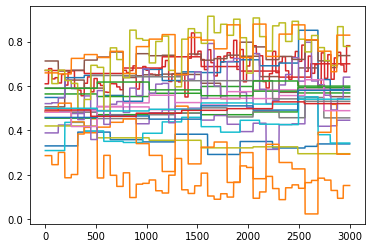

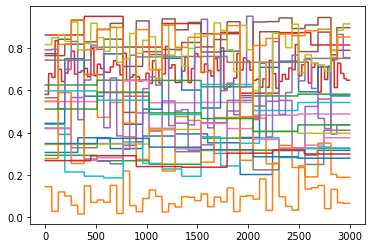

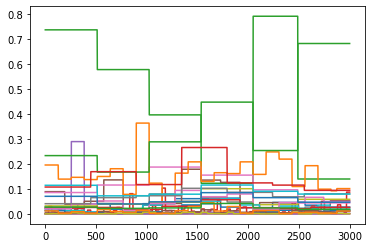

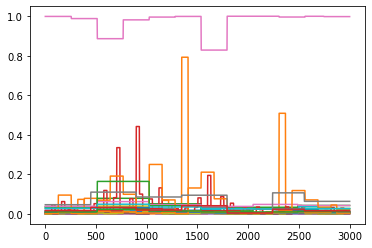

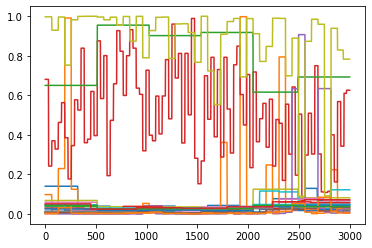

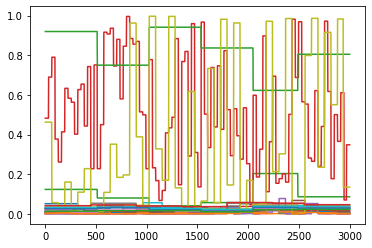

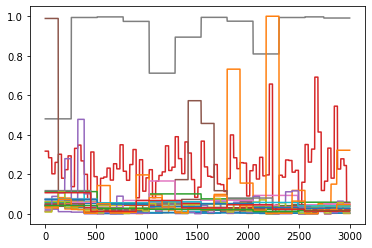

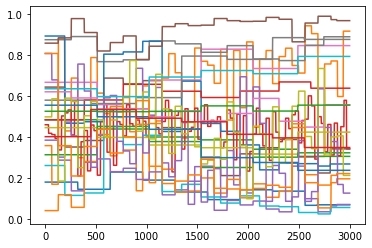

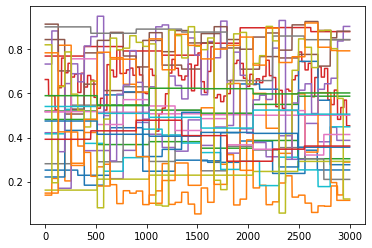

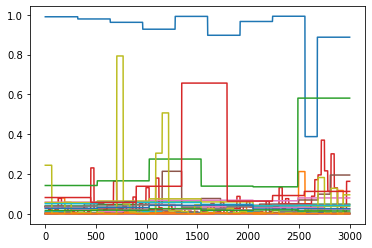

In [15]:
for i in range(10):
    plt.plot(df_pl['pl_fold_1'][i])
    plt.show()

## Train

In [16]:
if not DEBUG:
    log_folder = prepare_log_folder(LOG_PATH)
    print(f'Logging results to {log_folder}')
    create_logger(directory=log_folder, name="logs.txt")
    
for fold_idx in range(5):
    tf.keras.backend.clear_session()
    print(f"\n-------------   Fold {fold_idx + 1} / {5}  -------------\n")
    
    main(
        fold_idx,
        df_pl.copy(),
        log_folder, 
        pretrained_path=pretrained_folder + f"pretrained_best_fold{fold_idx}.h5", 
        pl_threshold=PL_THRESHOLD
    )
    
    gc.collect()
    if DEBUG:
        break


-------------   Fold 1 / 5  -------------

 -> Preparing Data 

 -> Preparing Model 

 -> Loading weights from ../logs/2021-02-04/3/pretrained_best_fold0.h5

 -> Training Model 

Epoch 1/100
Instructions for updating:
Use fn_output_signature instead
15/15 - 8s - loss: 0.5255 - lwlrap: 0.3976 - val_loss: 0.2897 - val_lwlrap: 0.3083
Epoch 2/100
15/15 - 6s - loss: 0.4666 - lwlrap: 0.4479 - val_loss: 0.3911 - val_lwlrap: 0.3236
Epoch 3/100
15/15 - 6s - loss: 0.5249 - lwlrap: 0.4511 - val_loss: 7.0301 - val_lwlrap: 0.1445
Epoch 4/100
15/15 - 6s - loss: 0.6859 - lwlrap: 0.4850 - val_loss: 3.0423 - val_lwlrap: 0.1498
Epoch 5/100


KeyboardInterrupt: 